In [1]:
import dagstermill

In [2]:
from dagster import ModeDefinition, ResourceDefinition
from collections import namedtuple

url = 'postgresql://{username}:{password}@{hostname}:5432/{db_name}'.format(
    username='test', password='test', hostname='localhost', db_name='test'
)
DbInfo = namedtuple('DbInfo', 'url')
context = dagstermill.get_context(
    mode_def=ModeDefinition(
        resource_defs={'db_info': ResourceDefinition(lambda _: DbInfo(url))}
    )
)

table_name = 'average_sfo_outbound_avg_delays_by_destination'

In [ ]:
db_url = context.resources.db_info.url

In [3]:
import os

import sqlalchemy as sa
import matplotlib.pyplot as plt
import pandas as pd

from dagster.utils import mkdir_p

In [4]:
engine = sa.create_engine(db_url)

/Users/max/.virtualenvs/dagster/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
from matplotlib.backends.backend_pdf import PdfPages
plots_path = os.path.join(os.getcwd(), 'plots')
mkdir_p(plots_path)
pdf_path = os.path.join(plots_path, 'sfo_delays_by_destination.pdf')
pp = PdfPages(pdf_path)

In [6]:
delays = pd.read_sql('select * from {table_name}'.format(table_name=table_name), engine)

In [7]:
delays.head()

,arrival_delay,departure_delay,origin,destination
0,10.0,16.0,SFO,EUG
1,-4.0,-5.0,SFO,BOS
2,13.0,0.0,SFO,SAN
3,-22.0,-1.0,SFO,MCO
4,-3.0,-4.0,SFO,LAS


/Users/max/.virtualenvs/dagster/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/max/.virtualenvs/dagster/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


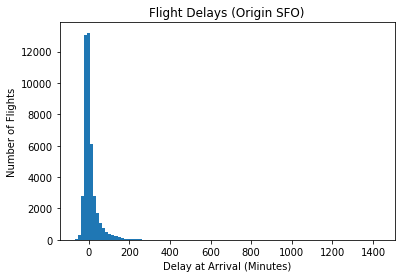

In [8]:
plt.hist(delays['arrival_delay'], bins=100)
plt.title('Flight Delays (Origin SFO)')
plt.xlabel('Delay at Arrival (Minutes)')
plt.ylabel('Number of Flights')
pp.savefig()

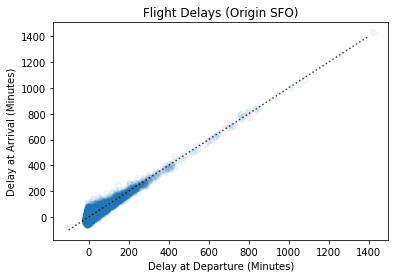

In [9]:
plt.scatter(delays['departure_delay'], delays['arrival_delay'], alpha=.05)
plt.plot([-100,1400], [-100,1400], 'k:', alpha=0.75)
plt.title('Flight Delays (Origin SFO)')
plt.xlabel('Delay at Departure (Minutes)')
plt.ylabel('Delay at Arrival (Minutes)')
pp.savefig()

In [10]:
(delays['departure_delay'] - delays['arrival_delay']).describe()

count    44011.000000
mean         3.521801
std         14.436305
min       -123.000000
25%         -4.000000
50%          5.000000
75%         12.000000
max         65.000000
dtype: float64

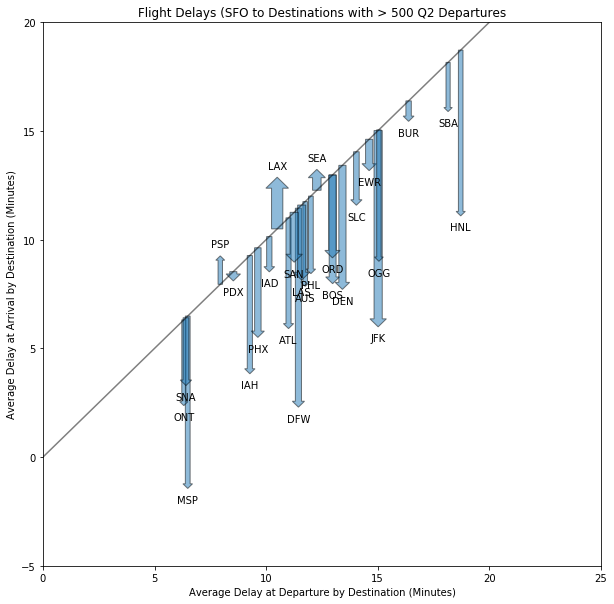

In [11]:
departure_delays_by_destination = delays.groupby('destination').mean()['departure_delay']
arrival_delays_by_destination = delays.groupby('destination').mean()['arrival_delay']
n_flights_by_destination = delays.groupby('destination').count()['origin']

import math
fig, ax = plt.subplots(figsize=(10,10))

# ax.scatter(
#     departure_delays_by_destination,
#     arrival_delays_by_destination,
#     s=n_flights_by_destination.map(math.sqrt),
#     alpha=0.5
# )
plt.xlim(0, 25)
plt.ylim(-5, 20)
plt.plot([-5,20], [-5,20], 'k-', alpha=0.5)


for i, destination in enumerate(n_flights_by_destination.index):
    departure_delay = departure_delays_by_destination[i]
    arrival_delay = arrival_delays_by_destination[i]
    n_flights = n_flights_by_destination[i]
    if (departure_delay > 0 and departure_delay < 25 and arrival_delay > -25 and departure_delay < 25 and n_flights > 500):
        arrow_width = math.sqrt(n_flights/15000)
        arrow_head_width = 2 * arrow_width
        arrow_head_length = arrow_width
        improved = (arrival_delay - departure_delay) < 0
        annotation_y = arrival_delay + 0.3 if not improved else (arrival_delay - 0.3)
        ax.arrow(
            departure_delay,
            departure_delay,
            0,
            arrival_delay - departure_delay,
            width=arrow_width,
            head_length=arrow_head_length,
            head_width=arrow_head_width,
            alpha=0.5,
            length_includes_head=True)
        ax.annotate(
            destination,
            (departure_delay, annotation_y),
            horizontalalignment='center',
            verticalalignment=('top' if improved else 'bottom'))

plt.title('Flight Delays (SFO to Destinations with > 500 Q2 Departures')
plt.xlabel('Average Delay at Departure by Destination (Minutes)')
plt.ylabel('Average Delay at Arrival by Destination (Minutes)')
pp.savefig()

In [12]:
pp.close()

In [13]:
from dagster import LocalFileHandle
dagstermill.yield_result(LocalFileHandle(pdf_path))

'/Users/max/dev/dagster/python_modules/airline-demo/airline_demo/notebooks/plots/sfo_delays_by_destination.pdf'